In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("btcusd_1-min_data.csv")
data

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6746276,1.737245e+09,104335.00,104414.00,104335.00,104414.00,0.093376
6746277,1.737245e+09,104414.00,104414.00,104410.00,104410.00,0.014035
6746278,1.737245e+09,104410.00,104439.00,104410.00,104436.00,0.054424
6746279,1.737245e+09,104432.00,104432.00,104369.00,104381.00,0.039791


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6746281 entries, 0 to 6746280
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 308.8 MB


In [4]:
print(data.isnull().sum())

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


There is one missing value in timestamp column

In [5]:
data.dropna(inplace=True)

In [6]:
data.describe()

,Timestamp,Open,High,Low,Close,Volume
count,6.746280e+06,6.746280e+06,6.746280e+06,6.746280e+06,6.746280e+06,6.746280e+06
mean,1.527856e+09,1.467032e+04,1.467662e+04,1.466384e+04,1.467035e+04,5.458753e+00
std,1.169204e+08,1.991977e+04,1.992734e+04,1.991209e+04,1.991986e+04,2.292632e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.426617e+09,4.136700e+02,4.138300e+02,4.134700e+02,4.136600e+02,1.828465e-02
50%,1.527822e+09,6.268990e+03,6.270990e+03,6.266810e+03,6.269055e+03,5.000000e-01
75%,1.629027e+09,2.322215e+04,2.322958e+04,2.321500e+04,2.322300e+04,3.175225e+00
max,1.737245e+09,1.082930e+05,1.083640e+05,1.082040e+05,1.082760e+05,5.853852e+03


In [7]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.sort_values(by='Timestamp', ascending=True)

Check gaps larger than one day

In [8]:
time_diff = data['Timestamp'].diff()
not_consective_days = (time_diff > pd.Timedelta(days=1)).sum()
print(f"Number of instances with a gap of more than 1 day: {not_consective_days}")

Number of instances with a gap of more than 1 day: 0


In [9]:
print(data.columns)


Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


To predict the next day's high, low, and close prices, I create shifted columns for each of these values.

In [10]:
# Shift columns for next day's prices
data['Next_High'] = data['High'].shift(1)
data['Next_Low'] = data['Low'].shift(1)
data['Next_Close'] = data['Close'].shift(1)

# Drop the first row because it will have NaN for the next day's values
data = data.dropna(subset=['Next_High', 'Next_Low', 'Next_Close'])

In [11]:
data

,Timestamp,Open,High,Low,Close,Volume,Next_High,Next_Low,Next_Close
1,1970-01-01 00:00:01.325412120,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58
2,1970-01-01 00:00:01.325412180,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58
3,1970-01-01 00:00:01.325412240,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58
4,1970-01-01 00:00:01.325412300,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58
5,1970-01-01 00:00:01.325412360,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58
...,...,...,...,...,...,...,...,...,...
6746275,1970-01-01 00:00:01.737244560,104288.00,104335.00,104288.00,104335.00,0.404987,104288.00,104286.00,104288.00
6746276,1970-01-01 00:00:01.737244620,104335.00,104414.00,104335.00,104414.00,0.093376,104335.00,104288.00,104335.00
6746277,1970-01-01 00:00:01.737244680,104414.00,104414.00,104410.00,104410.00,0.014035,104414.00,104335.00,104414.00
6746278,1970-01-01 00:00:01.737244740,104410.00,104439.00,104410.00,104436.00,0.054424,104414.00,104410.00,104410.00


### Moving Averages and Data Cleaning

- **MA_7 and MA_30**: These columns represent the 7-day and 30-day moving averages of the closing price, helping smooth short-term fluctuations and reveal long-term trends.

- **Why drop the first 3o rows?**: The first 29 rows have `NaN` values in `MA_30` due to the 30-day moving average calculation, so they are dropped to clean the dataset for model training.

In [12]:
# Calculate the 7-day moving average
data['MA_7'] = data['Close'].rolling(window=7).mean()

# Calculate the 30-day moving average
data['MA_30'] = data['Close'].rolling(window=30).mean()

# Display the data to verify
print(data[['Close', 'MA_7', 'MA_30']].head(40))


    Close  MA_7  MA_30
1    4.58   NaN    NaN
2    4.58   NaN    NaN
3    4.58   NaN    NaN
4    4.58   NaN    NaN
5    4.58   NaN    NaN
6    4.58   NaN    NaN
7    4.58  4.58    NaN
8    4.58  4.58    NaN
9    4.58  4.58    NaN
10   4.58  4.58    NaN
11   4.58  4.58    NaN
12   4.58  4.58    NaN
13   4.58  4.58    NaN
14   4.58  4.58    NaN
15   4.58  4.58    NaN
16   4.58  4.58    NaN
17   4.58  4.58    NaN
18   4.58  4.58    NaN
19   4.58  4.58    NaN
20   4.58  4.58    NaN
21   4.58  4.58    NaN
22   4.58  4.58    NaN
23   4.58  4.58    NaN
24   4.58  4.58    NaN
25   4.58  4.58    NaN
26   4.58  4.58    NaN
27   4.58  4.58    NaN
28   4.58  4.58    NaN
29   4.58  4.58    NaN
30   4.58  4.58   4.58
31   4.58  4.58   4.58
32   4.58  4.58   4.58
33   4.58  4.58   4.58
34   4.58  4.58   4.58
35   4.58  4.58   4.58
36   4.58  4.58   4.58
37   4.58  4.58   4.58
38   4.58  4.58   4.58
39   4.58  4.58   4.58
40   4.58  4.58   4.58


In [13]:
# Drop the first 30 rows with NaN values in the MA_30 column
data = data.dropna(subset=['MA_7', 'MA_30']).reset_index(drop=True)

# Display the updated data to verify
data.tail()

,Timestamp,Open,High,Low,Close,Volume,Next_High,Next_Low,Next_Close,MA_7,MA_30
6746245,1970-01-01 00:00:01.737244560,104288.0,104335.0,104288.0,104335.0,0.404987,104288.0,104286.0,104288.0,104318.285714,104387.833333
6746246,1970-01-01 00:00:01.737244620,104335.0,104414.0,104335.0,104414.0,0.093376,104335.0,104288.0,104335.0,104333.857143,104388.366667
6746247,1970-01-01 00:00:01.737244680,104414.0,104414.0,104410.0,104410.0,0.014035,104414.0,104335.0,104414.0,104344.857143,104388.666667
6746248,1970-01-01 00:00:01.737244740,104410.0,104439.0,104410.0,104436.0,0.054424,104414.0,104410.0,104410.0,104361.571429,104391.933333
6746249,1970-01-01 00:00:01.737244800,104432.0,104432.0,104369.0,104381.0,0.039791,104439.0,104410.0,104436.0,104364.571429,104393.400000


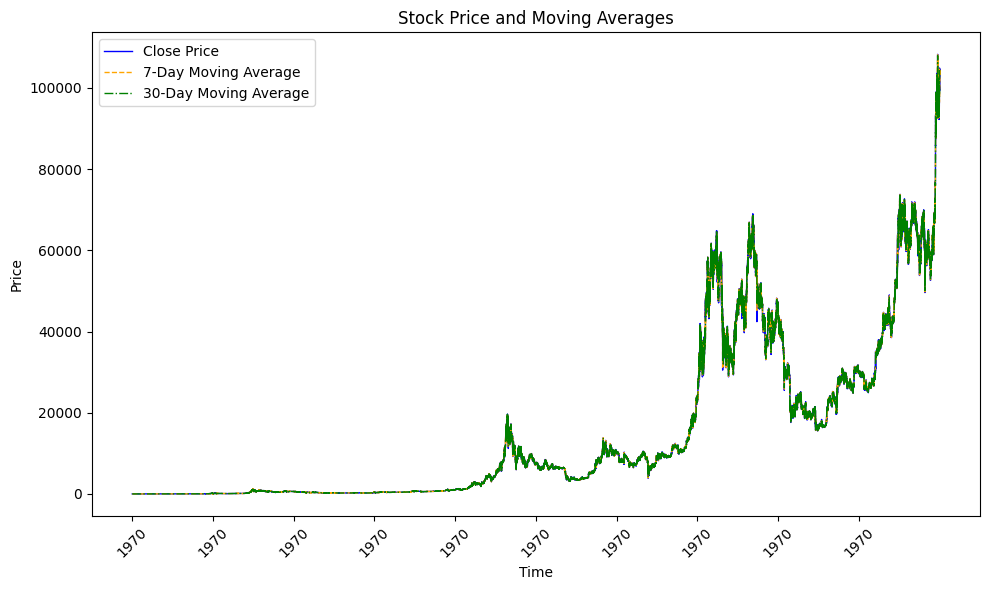

In [14]:
# Plot Close, MA_7, and MA_30 on the same chart
plt.figure(figsize=(10, 6))

# Plot Close price
plt.plot(data['Close'], label='Close Price', color='blue', linestyle='-', linewidth=1)

# Plot 7-day moving average
plt.plot(data['MA_7'], label='7-Day Moving Average', color='orange', linestyle='--', linewidth=1)

# Plot 30-day moving average
plt.plot(data['MA_30'], label='30-Day Moving Average', color='green', linestyle='-.', linewidth=1)

# Add titles and labels
plt.title('Stock Price and Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')

# Display the legend
plt.legend()

# Set x-axis to display year labels at intervals
data['Year'] = pd.to_datetime(data['Timestamp'], unit='s').dt.year
plt.xticks(range(0, len(data), len(data)//10), data['Year'][::len(data)//10], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

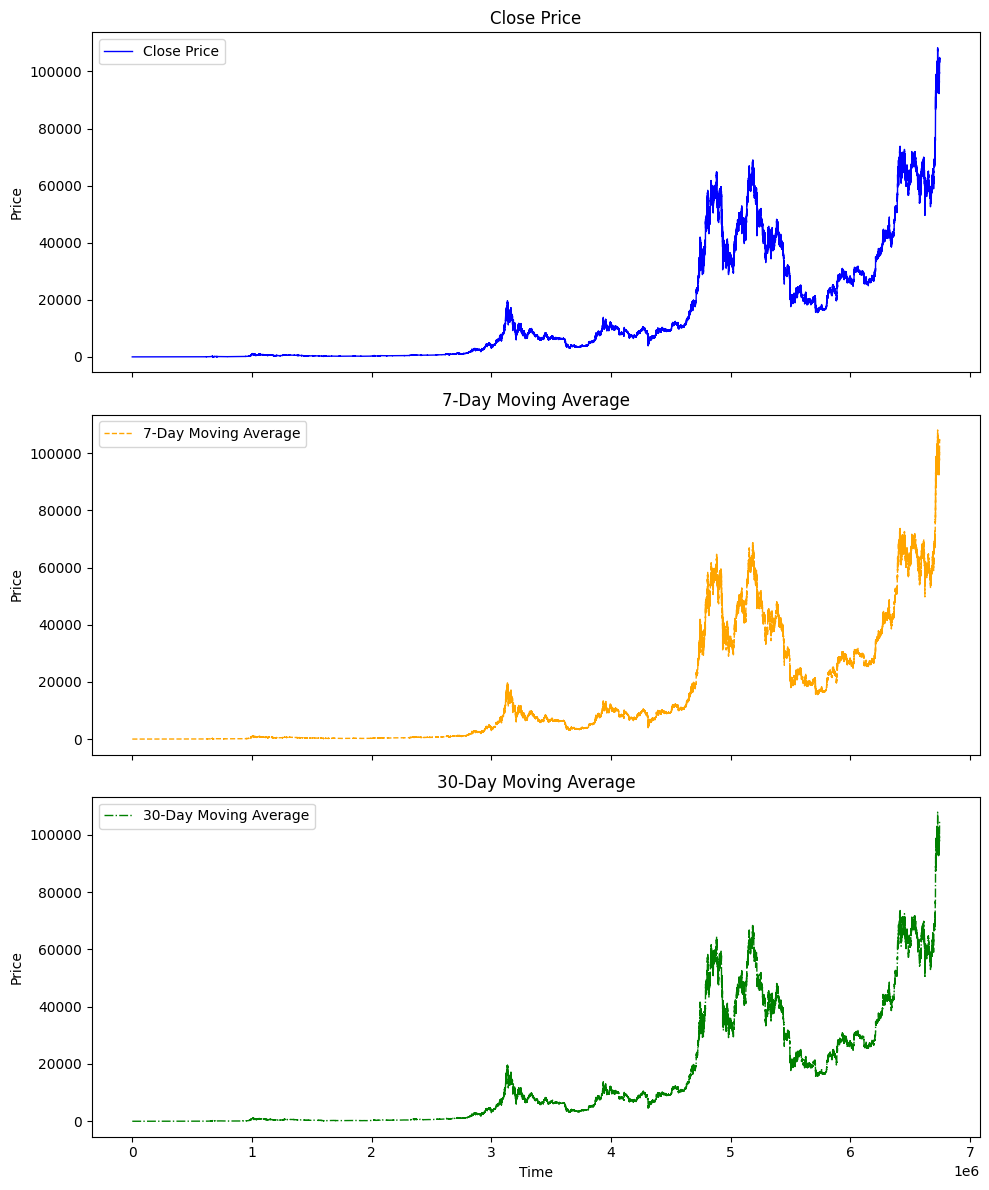

In [15]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Close price in the first subplot
axes[0].plot(data['Close'], label='Close Price', color='blue', linestyle='-', linewidth=1)
axes[0].set_title('Close Price')
axes[0].set_ylabel('Price')
axes[0].legend()

# Plot 7-day moving average in the second subplot
axes[1].plot(data['MA_7'], label='7-Day Moving Average', color='orange', linestyle='--', linewidth=1)
axes[1].set_title('7-Day Moving Average')
axes[1].set_ylabel('Price')
axes[1].legend()

# Plot 30-day moving average in the third subplot
axes[2].plot(data['MA_30'], label='30-Day Moving Average', color='green', linestyle='-.', linewidth=1)
axes[2].set_title('30-Day Moving Average')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Price')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# Drop the 'year' column which we made for plotting graph
data = data.drop(columns=['Year'])

### Dropping the Timestamp Column

The **Timestamp** column is dropped because it does not provide direct value for predicting the next day's stock prices based on the current day's features. Since the model uses data like Open, High, Low, Close, and Moving Averages to make predictions, the timestamp itself is not a relevant feature for this short-term prediction task. 

Additionally, storing or using the timestamp might introduce unnecessary complexity and noise into the model. The primary focus is on the relationship between current stock values, and the year, month, or exact timestamp does not contribute directly to this prediction process.


In [17]:
data = data.drop(columns=['Timestamp'])

In [18]:
data

,Open,High,Low,Close,Volume,Next_High,Next_Low,Next_Close,MA_7,MA_30
0,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58,4.580000,4.580000
1,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58,4.580000,4.580000
2,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58,4.580000,4.580000
3,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58,4.580000,4.580000
4,4.58,4.58,4.58,4.58,0.000000,4.58,4.58,4.58,4.580000,4.580000
...,...,...,...,...,...,...,...,...,...,...
6746245,104288.00,104335.00,104288.00,104335.00,0.404987,104288.00,104286.00,104288.00,104318.285714,104387.833333
6746246,104335.00,104414.00,104335.00,104414.00,0.093376,104335.00,104288.00,104335.00,104333.857143,104388.366667
6746247,104414.00,104414.00,104410.00,104410.00,0.014035,104414.00,104335.00,104414.00,104344.857143,104388.666667
6746248,104410.00,104439.00,104410.00,104436.00,0.054424,104414.00,104410.00,104410.00,104361.571429,104391.933333


### Dropping MA_7, MA_30:
We cannot compute **MA_7** and **MA_30** for future predictions as they rely on past data points. Since the model will predict future values based on the current day's data (Open, High, Low, Close, Volume), including **MA_7** and **MA_30** would not make sense for future instances. Therefore, these columns are dropped to ensure the model uses only the required features.


In [19]:
data = data.drop(columns=['MA_7', 'MA_30'])

In [20]:
data.describe()

,Open,High,Low,Close,Volume,Next_High,Next_Low,Next_Close
count,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06
mean,1.467038e+04,1.467668e+04,1.466390e+04,1.467041e+04,5.458777e+00,1.467667e+04,1.466389e+04,1.467040e+04
std,1.991979e+04,1.992736e+04,1.991211e+04,1.991988e+04,2.292637e+01,1.992733e+04,1.991208e+04,1.991985e+04
min,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00,3.800000e+00,3.800000e+00,3.800000e+00
25%,4.136800e+02,4.138300e+02,4.134800e+02,4.136600e+02,1.828632e-02,4.138300e+02,4.134800e+02,4.136600e+02
50%,6.268995e+03,6.271000e+03,6.266840e+03,6.269145e+03,5.000000e-01,6.271000e+03,6.266840e+03,6.269140e+03
75%,2.322254e+04,2.322990e+04,2.321500e+04,2.322300e+04,3.175240e+00,2.322986e+04,2.321500e+04,2.322300e+04
max,1.082930e+05,1.083640e+05,1.082040e+05,1.082760e+05,5.853852e+03,1.083640e+05,1.082040e+05,1.082760e+05


In [21]:
# Select the columns to standardize
features = data.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the selected columns
data[features] = scaler.fit_transform(data[features])

In [22]:
data.describe()

,Open,High,Low,Close,Volume,Next_High,Next_Low,Next_Close
count,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06,6.746250e+06
mean,-6.578965e-17,-3.882668e-17,2.814934e-16,-3.645394e-16,-9.617355e-17,-1.191763e-16,1.687882e-16,-2.264890e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.362820e-01,-7.363185e-01,-7.362405e-01,-7.362801e-01,-2.381004e-01,-7.363188e-01,-7.362408e-01,-7.362804e-01
25%,-7.157055e-01,-7.157423e-01,-7.156661e-01,-7.157047e-01,-2.373028e-01,-7.157426e-01,-7.156663e-01,-7.157050e-01
50%,-4.217609e-01,-4.218162e-01,-4.217062e-01,-4.217529e-01,-2.162915e-01,-4.218160e-01,-4.217061e-01,-4.217530e-01
75%,4.293298e-01,4.292198e-01,4.294422e-01,4.293493e-01,-9.960313e-02,4.292193e-01,4.294436e-01,4.293508e-01
max,4.699980e+00,4.701443e+00,4.697649e+00,4.699104e+00,2.550947e+02,4.701451e+00,4.697657e+00,4.699112e+00


In [23]:
X = data.drop(columns=['Next_High',	'Next_Low',	'Next_Close'])
y = data[['Next_High',	'Next_Low',	'Next_Close']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Comparison and Evaluation

## Objective:
We compared multiple machine learning models to predict the target variables in a big dataset. The goal was to determine the best model for the task based on accuracy and performance on the test set.

## Models Tested:
- **Linear Regression**
- **Random Forest**
- **XGBoost**
- **K-Nearest Neighbors (KNN)**

## Test Set Performance:

### 1. **Linear Regression**
   - **RMSE:** 0.00082
   - **MAE:** 0.00029
   - **R²:** 0.999999

   **Conclusion:** Linear Regression performed exceptionally well on the test set with very low error and nearly perfect R², indicating that it generalizes well to unseen data.

### 2. **Random Forest**
   - **RMSE:** 0.00116
   - **MAE:** 0.00046
   - **R²:** 0.999998

   **Conclusion:** Random Forest performed slightly worse than Linear Regression in terms of RMSE and MAE, though it still showed excellent performance.

### 3. **XGBoost**
   - **RMSE:** 0.03158
   - **MAE:** 0.00526
   - **R²:** 0.99900

   **Conclusion:** XGBoost showed higher error metrics compared to Linear Regression and Random Forest, but still performed well in capturing the relationship.

### 4. **K-Nearest Neighbors (KNN)**
   - **RMSE:** 0.00524
   - **MAE:** 0.00089
   - **R²:** 0.99997

   **Conclusion:** KNN showed higher RMSE compared to Linear Regression, but performed fairly well on other metrics.

## Final Decision:
After testing all models, **Linear Regression** emerged as the best-performing model on the test set. It provided the most accurate predictions with the lowest RMSE, MAE, and the highest R² value.

### Why Linear Regression is the Best Choice:
- **Simplicity and Efficiency:** Linear Regression is a simple and efficient model that, despite its simplicity, provided outstanding results.
- **Excellent Test Set Performance:** The model performed almost perfectly on unseen data, suggesting it generalizes well.
- **No Need for Complex Models:** More complex models such as Random Forest and XGBoost did not provide significant improvements over Linear Regression, making Linear Regression the optimal choice for this task.

## Conclusion:
While we explored more complex models, **Linear Regression** proved to be the most effective and efficient for this particular dataset, achieving nearly perfect test set accuracy.

In [24]:
# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluate the model
print("Linear Regression - Performance:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"R2: {r2_score(y_test, y_pred_lr)}")


Linear Regression - Performance:
RMSE: 0.0008283875945416389
MAE: 0.00029125166368755605
R2: 0.9999992898094634
